In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

### 1. Data Gathering

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'KEY')

In [4]:
dinasor_types = 'Trex', 'Stegosaurus', 'Brachiosaurus'

In [5]:
path = Path('dinasor')

In [6]:
if not path.exists():
    path.mkdir()

In [7]:
for d in dinasor_types:
    dest = (path/d)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{d} dinasor')
    download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)

In [9]:
fns

(#593) [Path('dinasor/Brachiosaurus/00000022.png'),Path('dinasor/Brachiosaurus/00000099.jpeg'),Path('dinasor/Brachiosaurus/00000047.jpg'),Path('dinasor/Brachiosaurus/00000055.jpg'),Path('dinasor/Brachiosaurus/00000034.png'),Path('dinasor/Brachiosaurus/00000011.png'),Path('dinasor/Brachiosaurus/00000075.jpeg'),Path('dinasor/Brachiosaurus/00000107.jpg'),Path('dinasor/Brachiosaurus/00000036.jpg'),Path('dinasor/Brachiosaurus/00000030.jpg')...]

In [10]:
dest = 'dinasor/Trex/00000008.jpg'

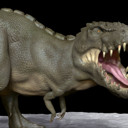

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

In [12]:
failed_images = verify_images(fns)

In [13]:
failed_images.map(Path.unlink)

(#4) [None,None,None,None]

In [14]:
dinasor = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = dinasor.dataloaders(path)

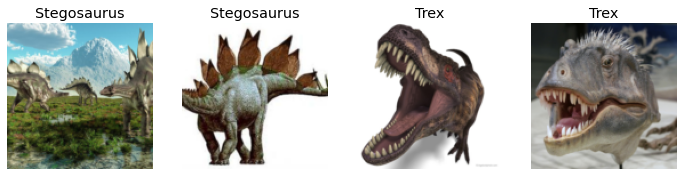

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

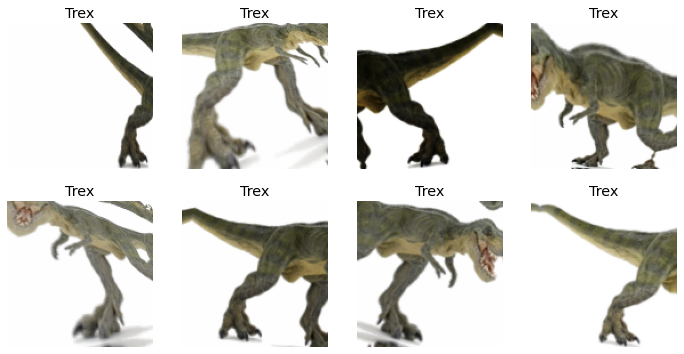

In [17]:
dinasor = dinasor.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dinasor.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### 2. Train My Model

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.678157,0.468922,0.136752,00:18


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.713791,0.285608,0.094017,00:17
1,0.587493,0.217112,0.085470,00:16
2,0.506426,0.164720,0.051282,00:16
3,0.422027,0.149004,0.042735,00:16


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency e

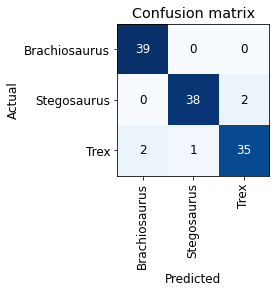

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

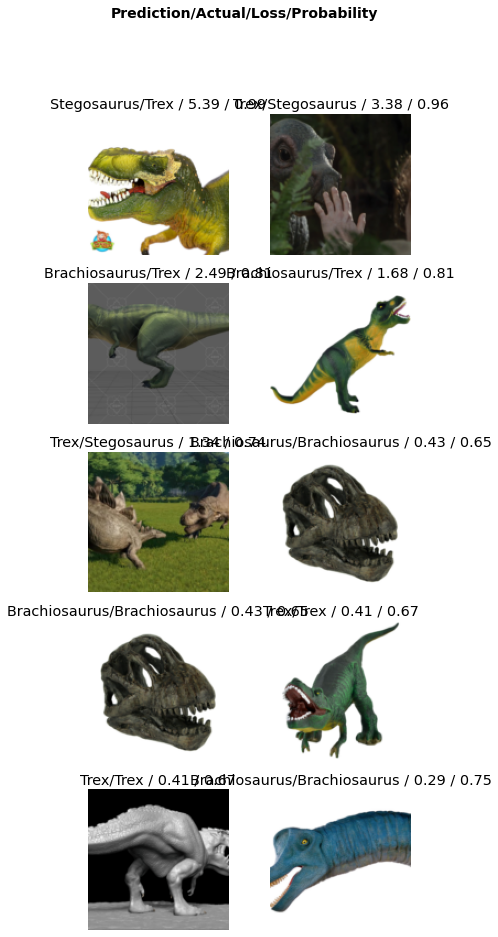

In [20]:
interp.plot_top_losses(10, nrows = 5)

### 3. Data Cleaning

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [23]:
learn.predict('dinasor/Trex/00000000.jpg')

('Trex', TensorBase(2), TensorBase([1.3644e-05, 7.6618e-09, 9.9999e-01]))

In [24]:
learn.dls.vocab

['Brachiosaurus', 'Stegosaurus', 'Trex']

### 4. Export the model 

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]